### Importing libraries

In [4]:
import pandas as pd
import numpy as np
import missingno
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


### Reading data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### 3.  Data Dictionary:*
Survival: 0 = No, 1 = Ye
*  pclass: Ticket class 1 = 1st, 2 = 2nd  3 = r
* rs sibsp: # of siblings / spouses aboard the Titan
* ic parch: # of parents / children aboard the Titan
* ic ticket: Ticket numb
* er fare: Passenger fa
* re cabin: Cabin num
* Age: Age in years 
* sex: Sex
* er embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

### 4. Exploratory Data Analysis (EDA)

* .info()
* isnull().sum().sort_values()
* missingno.matrix()
* describe()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


<Axes: >

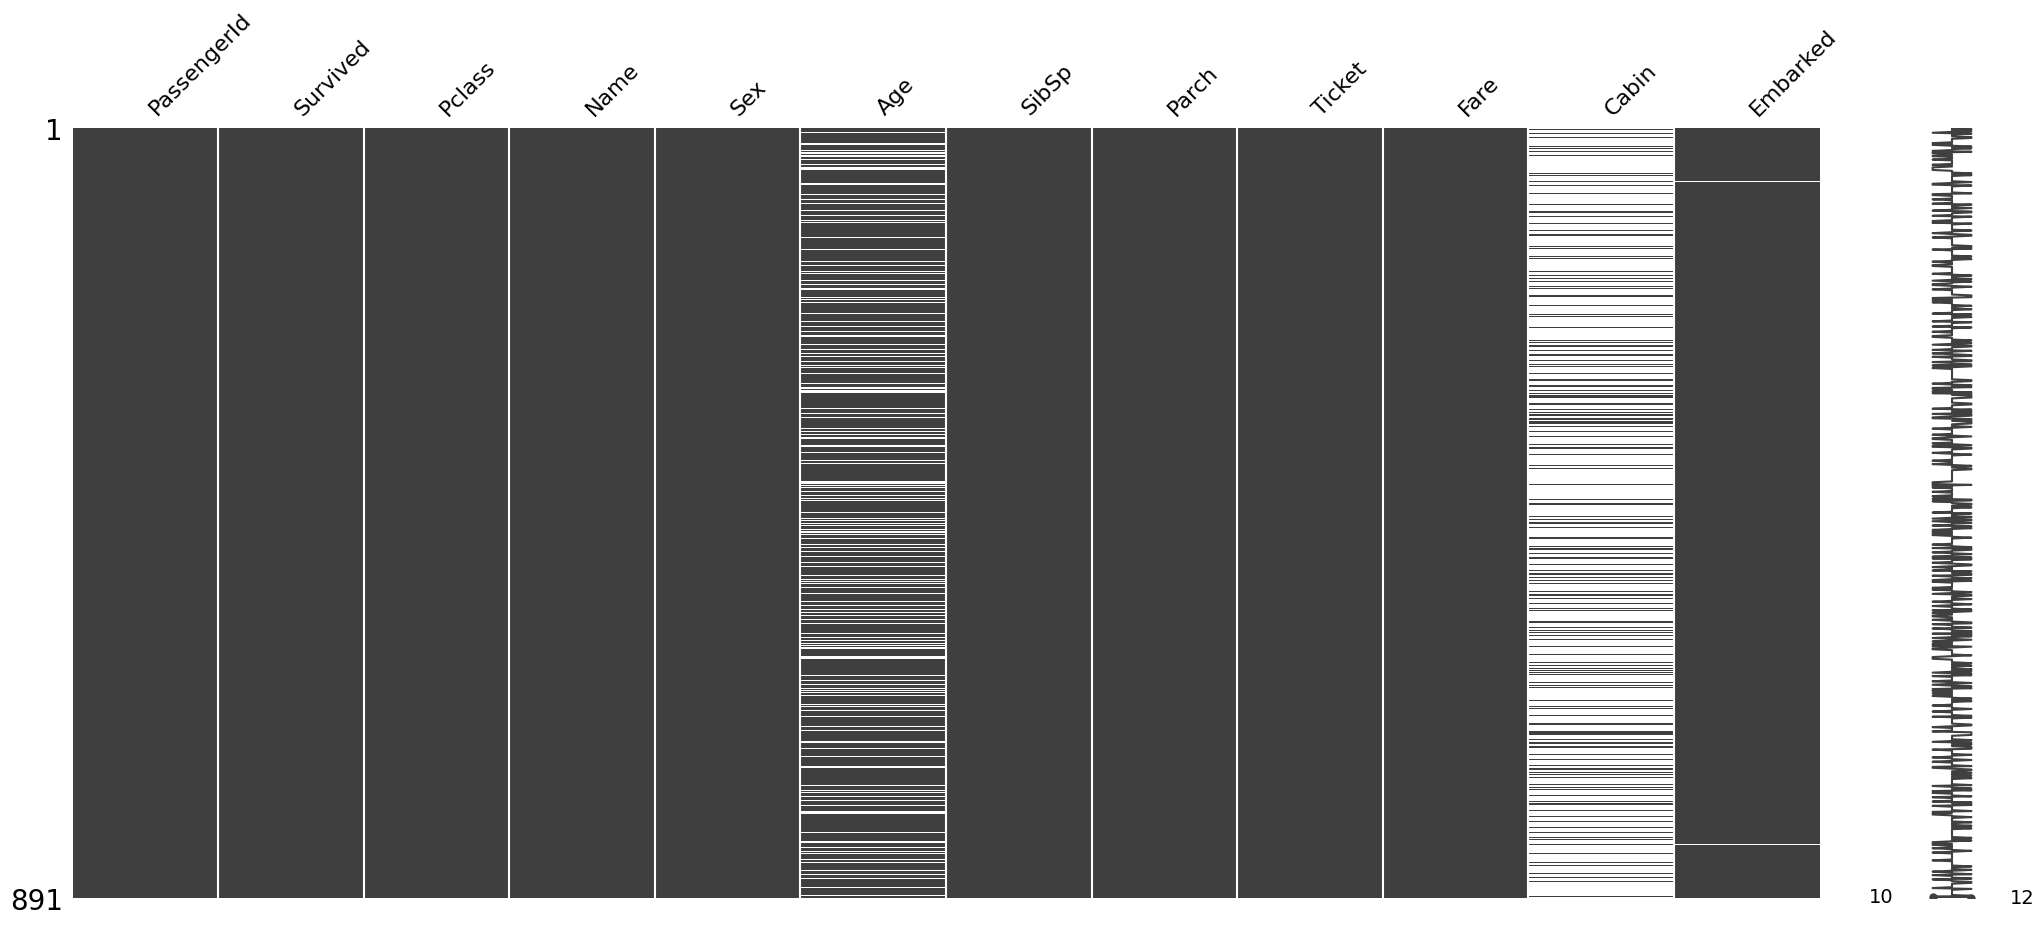

In [12]:
missingno.matrix(train)

<Axes: >

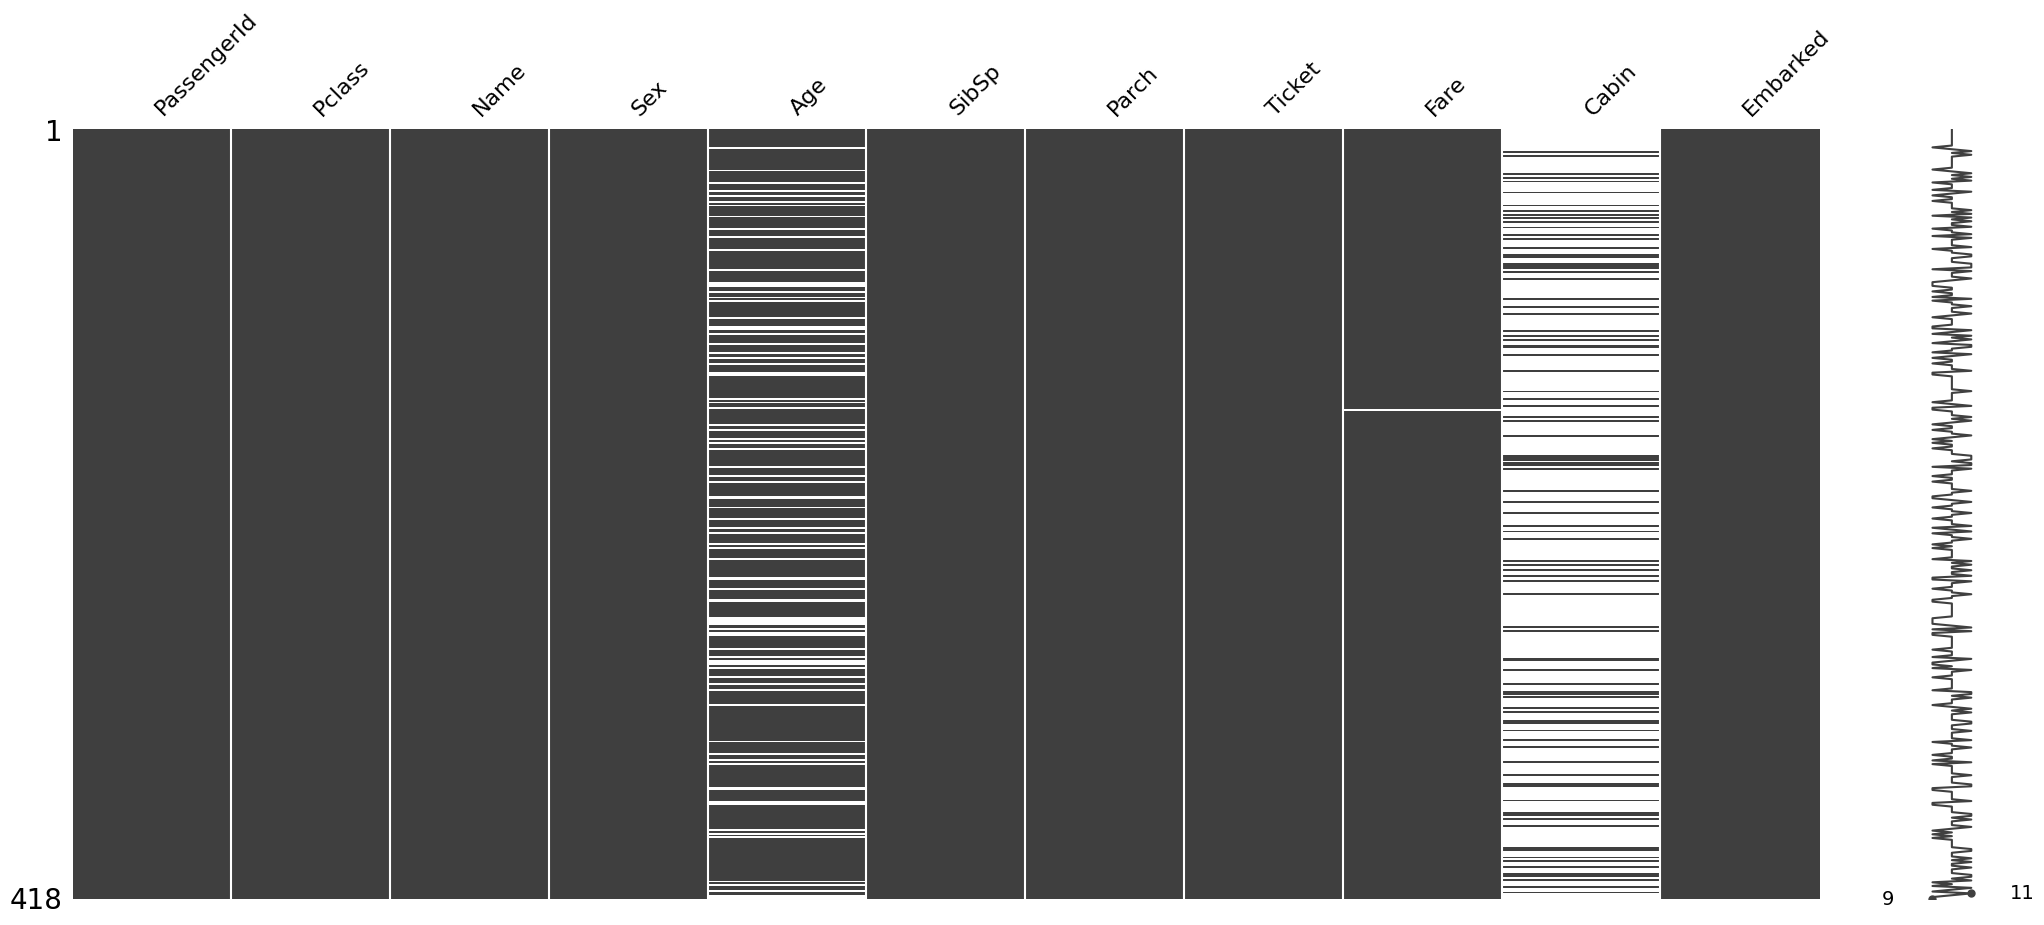

In [13]:
missingno.matrix(test)

In [14]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [15]:
test.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

In [16]:
train.query('Embarked == "Q"')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
790,791,0,3,"Keane, Mr. Andrew ""Andy""",male,NaN,0,0,12460,7.7500,NaN,Q
825,826,0,3,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


#### 4.1 Feature Analysis

* PassengerId - index
* Survived - target feature

##### Categorical features:
* Pclass - cat
* Name - cat
* Sex - cat
* Cabin - cat
* Embark - cat

##### Numerical features
* Age - num
* SibSp - num
* Parch - num
* Ticket - num
* Fare - num

#### 4.2 Categorical features
* 4.2.1 Pclass - cat
* 4.2.2 Name - cat
* 4.2.3 Sex - cat
* 4.2.4 Cabin - cat
* 4.2.5 Embark - cat
* 4.3.5 Ticket - cat

##### 4.2.1 Pclass

In [17]:
train.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [18]:
train[['Parch','SibSp','Age','Pclass','Survived']].groupby('Pclass').mean().sort_values('Survived', ascending=False)

,Parch,SibSp,Age,Survived
Pclass,,,,
1,0.356481,0.416667,38.233441,0.629630
2,0.380435,0.402174,29.877630,0.472826
3,0.393075,0.615071,25.140620,0.242363


In [19]:
Pclass_sur_mean = train.groupby('Pclass')['Survived'].mean()
Pclass_sur_mean

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

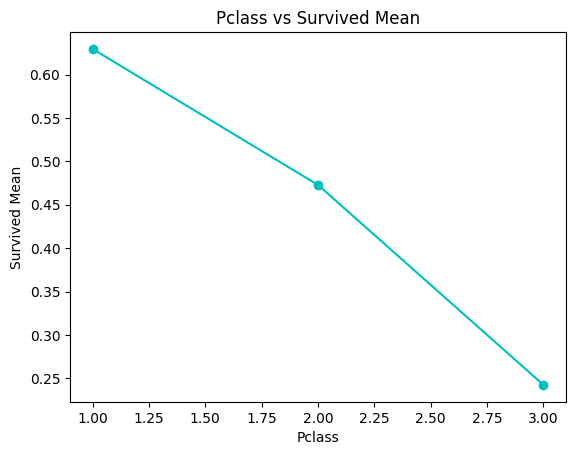

In [20]:
Pclass_sur_mean.plot(marker='o', linestyle='-', color='c')
plt.title('Pclass vs Survived Mean')
plt.xlabel('Pclass')
plt.ylabel('Survived Mean')

plt.show()

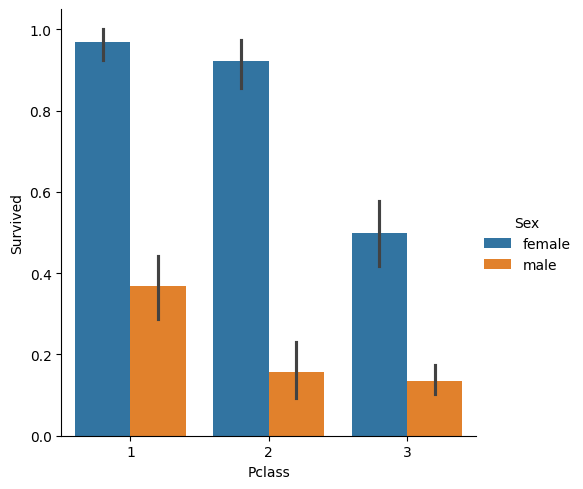

In [21]:
sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', kind='bar')

In [22]:
train[['Pclass', 'Sex']].groupby(['Pclass', 'Sex']).size().unstack(fill_value=0)

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


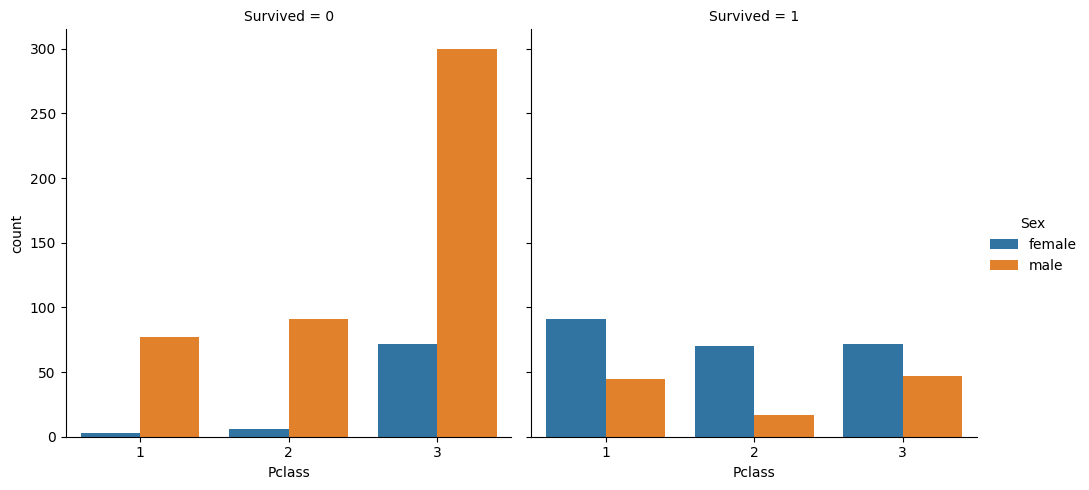

In [23]:
sns.catplot(data=train, x='Pclass', col='Survived', hue='Sex', kind='count')

##### 4.2.2 Name

In [24]:
train.Name.isnull().sum()

0

In [25]:
train.Name.nunique()

891

Names wont tell us anything at this stage, but we clearly see that there are titles in each name like: "Mr" and "Miss" or "Master". I think this will be usefull for replacing Nan values in age column, as well as it might be interesting feature to engineer in feature engineering part of this project.

##### 4.2.3 Sex

In [26]:
train.Sex.isnull().sum()

0

In [27]:
train.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [28]:
survival_by_sex = train.groupby('Sex')['Survived'].mean()
survival_by_sex

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

<Axes: xlabel='Sex', ylabel='Survived'>

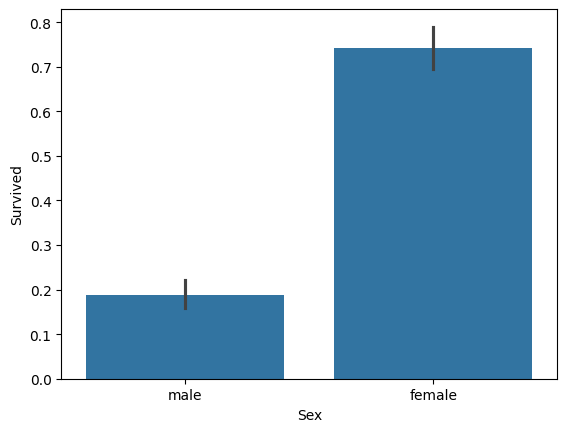

In [29]:
sns.barplot(data=train, x='Sex', y='Survived')

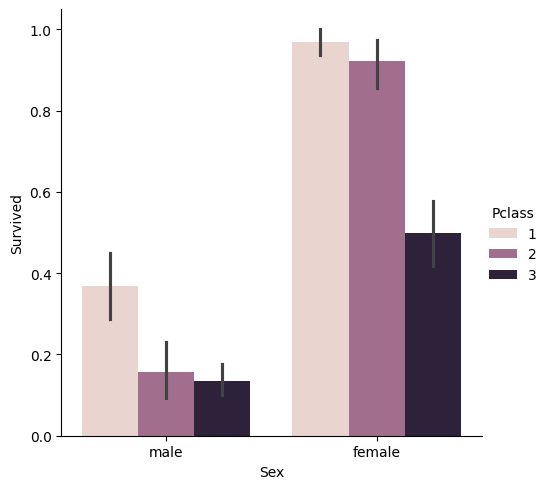

In [30]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Pclass', kind='bar')

We can clearly see that overall women had highest survival rate, especially those from first and second class. We can assume that when we fill Age NaN's we can get even better picture with enginnered feature "children" that we will separate from both male and female features.

##### 4.2.4 Cabin

In [31]:
train['Cabin'] = train['Cabin'].astype(str)
test['Cabin'] = test['Cabin'].astype(str)

In [32]:
train.query('Cabin.notnull()').groupby('Cabin')['Survived'].mean()

Cabin
A10    0.000000
A14    0.000000
A16    1.000000
A19    0.000000
A20    1.000000
         ...   
F38    0.000000
F4     1.000000
G6     0.500000
T      0.000000
nan    0.299854
Name: Survived, Length: 148, dtype: float64

In Feature engineering part I will try to use cabin feature to vreate a new one.

##### 4.2.5 Embarked

In [33]:
train.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [34]:
train.Embarked.isnull().sum()

2

In [35]:
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

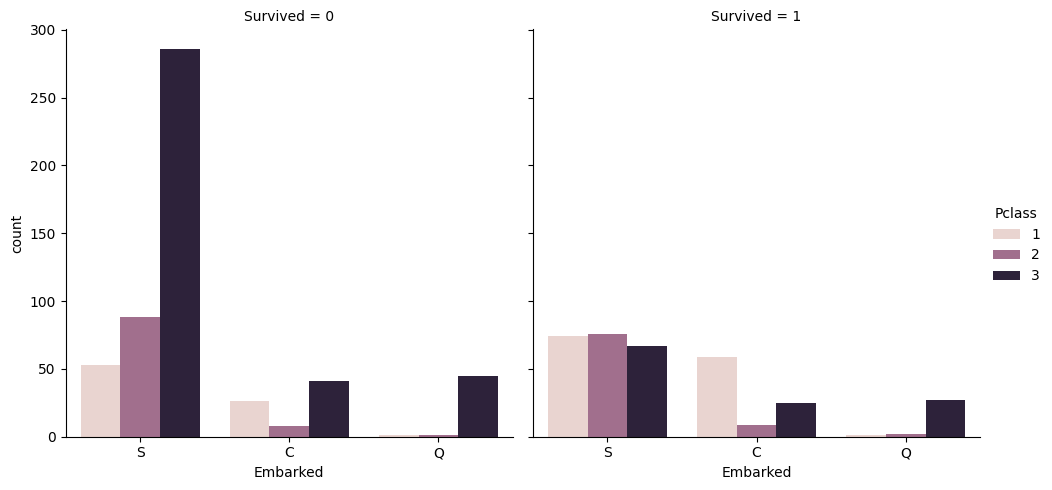

In [36]:
sns.catplot(data=train, x='Embarked', col='Survived', hue='Pclass' , kind='count' )

##### 4.3.5 Ticket

##### 4.3 Numerical features.
* 4.3.1 Detecting and removing outliers
* 4.3.2 Age - num
* 4.3.3 SibSp - num
* 4.3.4 Parch - num
* 4.3.5 Fare - num

##### 4.3.1 Detecting and removing outliers.

In [37]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S


In [38]:
def outlier_detection(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier)
    outlier_indices = Counter(outlier_indices)
    outlier_frequency = list(key for key, value in outlier_indices.items() if value > n)
    return outlier_frequency

print(outlier_detection(train, 2, ['Age', 'SibSp', 'Parch', 'Fare']))

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [39]:
outlier_indices = outlier_detection(train, 2, ['Age', 'SibSp','Parch', 'Fare'])
filtered_train = train.query('index in @outlier_indices').sort_values('Fare', ascending=False)
filtered_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,nan,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,nan,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,nan,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,nan,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,nan,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,nan,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,nan,S


Although using a general definition of outliers, we have found 10 indices that fit the definition after close inspection I dont belive they should be removed. Those 10 indices are people that payed a lot more then the median for their ticket and are very young or have a lot of siblings. The purpose of finding outliers is to  identify and remove sensor errors, spreadsheet sums, typos or unuasal high values. After close inspection I belive all 10 indices to be valued data points and not outliers.

In [40]:
train.query('Pclass == 1 & Fare > 150').sort_values('Fare', ascending=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.00,0,0,PC 17755,512.3292,B101,C
258,259,1,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,nan,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.00,0,1,PC 17755,512.3292,B51 B53 B55,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.00,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.00,1,4,19950,263.0000,C23 C25 C27,S
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C


##### 4.3.2 Age.

In [41]:
train.Age.isnull().sum()

177

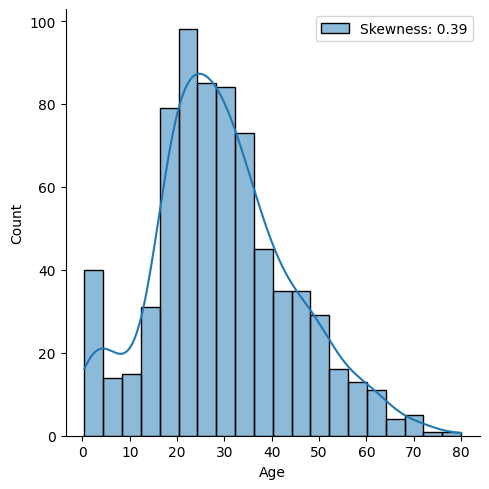

In [42]:
sns.displot(data=train, x='Age', kde=True, label='Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc='best')

In [43]:
train.groupby('Age')['Survived'].mean()

Age
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64

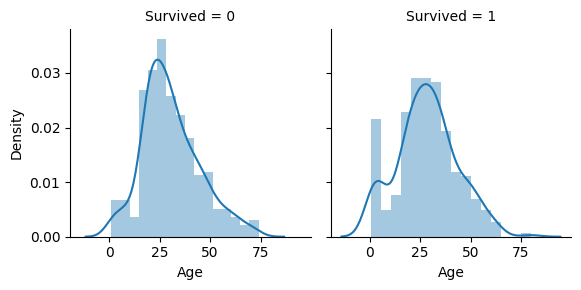

In [44]:
g = sns.FacetGrid(train, col='Survived')

g.map(sns.distplot, 'Age')

##### 4.3.3 SibSp.

In [45]:
train.SibSp.value_counts(dropna=False)

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [46]:
train.SibSp.isnull().sum()

0

In [47]:
train.groupby('SibSp')['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

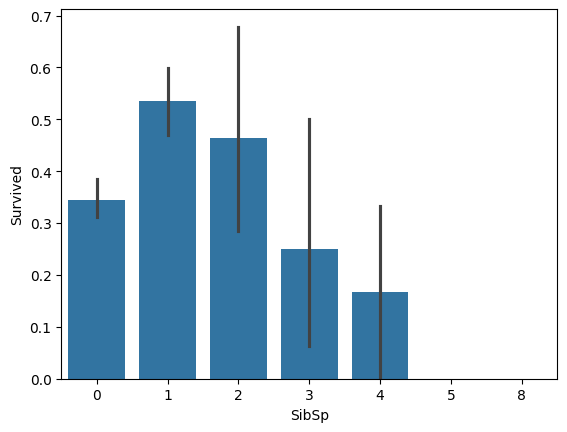

In [48]:
sns.barplot(data=train, x='SibSp', y='Survived')
plt.show()

#### 4.3.4 Parch.

In [49]:
train.Parch.value_counts(dropna=False)

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [50]:
train.Parch.isnull().sum()

0

In [51]:
train.groupby('Parch')['Survived'].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

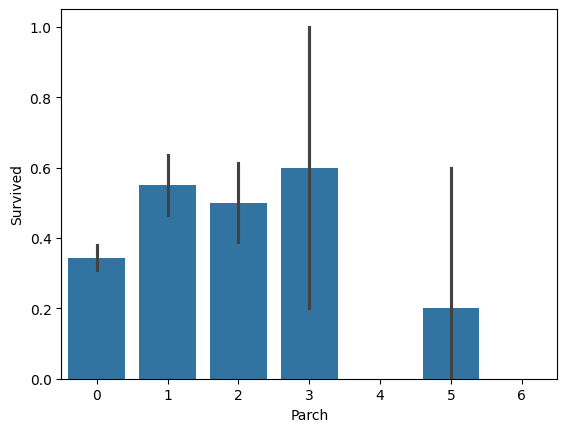

In [52]:
sns.barplot(data=train, x='Parch', y='Survived')
plt.show()

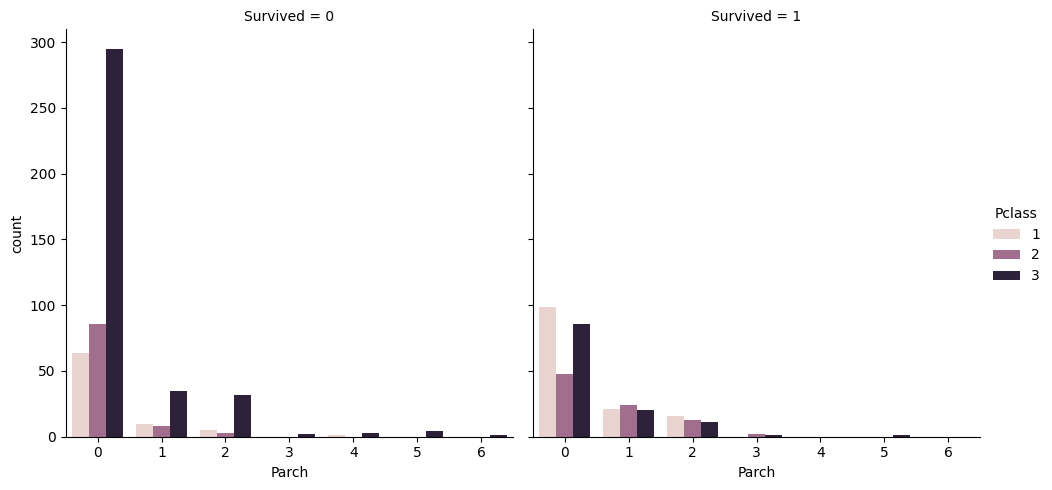

In [53]:
sns.catplot(data=train, x='Parch', col='Survived', hue='Pclass', kind='count')

##### 4.3.5 Fare

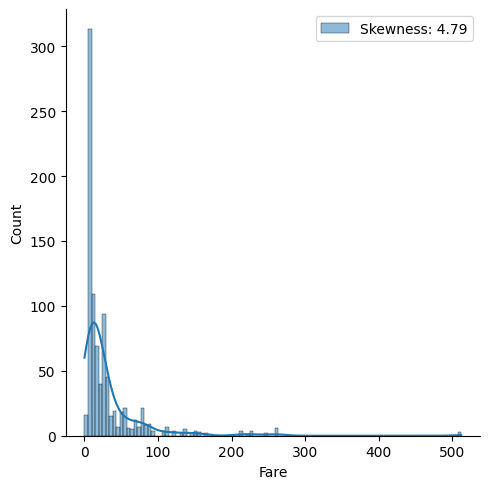

In [54]:
sns.displot(data=train, x='Fare', kde='True', label='Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc='best')

### 5. Data preprocesing
Data preprocesing is the process of getting our dataset ready for model training.
In this section we will perform the following preprocessing steps:* 5.1

* Drop and fill missing va in train and test datasets.
*  5.1.1 concat datasets train and test.
*      5.1.1.1 Embarked.
*      5.1.1.2 Age.ati 5.1.2 on
* Feature engin.
*      5.1.2 "Title"eering
* Feature e
* Data transformationncoding

##### 5.1 Drop and fill missing values in train and test datasets.
*  5.1.1 Train dataset.


##### 5.1.1.1 Embarked.

In [55]:
mode = train.Embarked.dropna().mode()[0]
mode

'S'

In [56]:
train['Embarked'] = train.Embarked.fillna(mode)

In [57]:
median = test.Fare.dropna().median()
median

14.4542

In [58]:
test.Fare = test.Fare.fillna(median)

In [59]:
combine = pd.concat([train,test], axis=0).reset_index(drop=True)

In [60]:
combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})


In [61]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,nan,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,nan,S


<Axes: >

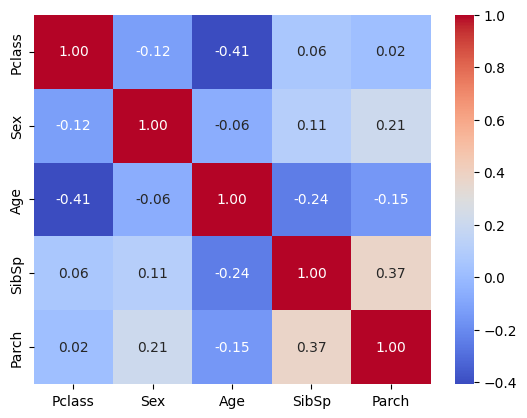

In [62]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId','Ticket', 'Cabin', 'Fare', 'Embarked'], axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')

##### 5.1.1.2 Age.

In [63]:
combine['Title'] = [title.split(',')[1].split('.')[0].strip() for title in combine.Name]

In [64]:
combine.Title.value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [65]:
nan_idx = combine.query('Age.isnull()').index
nan_idx

Index([   5,   17,   19,   26,   28,   29,   31,   32,   36,   42,
       ...
       1256, 1257, 1271, 1273, 1275, 1299, 1301, 1304, 1307, 1308],
      dtype='int64', length=263)

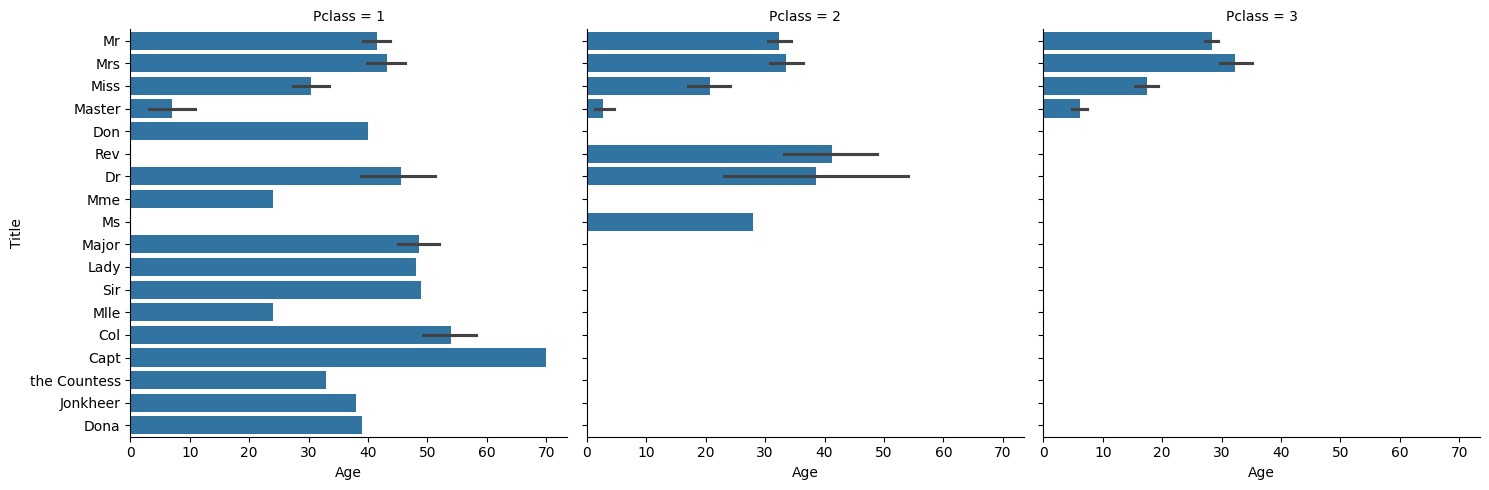

In [66]:
sns.catplot(data=combine, x='Age', y='Title',col='Pclass', kind='bar')

In [67]:
# no_people = []
# for idx in nan_idx:
#     age_val = train['Age'][(train['Title'] == train.loc[idx, 'Title'])
#                             & (train['Pclass'] == train.loc[idx,'Pclass'])
#                             & (train['SibSp'] == train.loc[idx,'SibSp'])
#                             & (train['Parch'] == train.loc[idx,'Parch'])]
    
#     plt.bar(range(len(age_val)), age_val)
#     plt.title(f'Ages for Index {idx}')
#     plt.xlabel('Person Index')
#     plt.ylabel('Age')
#     plt.show()
#     no_people.append(age_val)



In [68]:
for idx in nan_idx:
    median_age = combine['Age'][(combine['Title'] == combine.loc[idx, 'Title'])].median()
    sibsp_val = combine.loc[idx, 'SibSp']
    pclass_val = combine.loc[idx, 'Pclass']
    predicted_age = combine['Age'][ (combine['Title'] == combine.loc[idx, 'Title'])
                                & (combine['Pclass'] == pclass_val)
                                & (combine['SibSp'] == sibsp_val)
                                & (combine['Parch'] == combine.loc[idx,'Parch'])].median()
    if np.isnan(predicted_age):
        combine.loc[idx,'Age'] = median_age
        
    else:
        combine.loc[idx,'Age'] = predicted_age

    

In [69]:
combine.Age.isnull().sum()

0

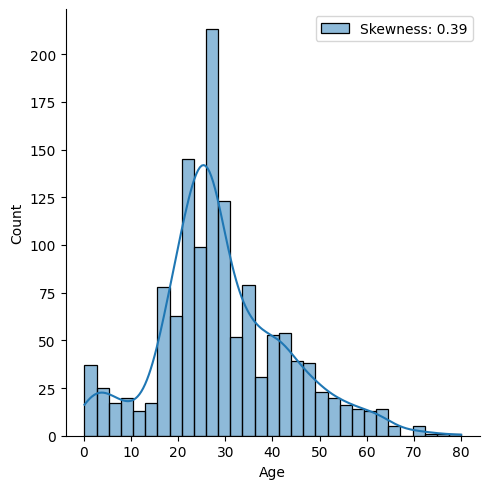

In [70]:
sns.displot(data=combine, x='Age', kde=True, label='Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc='best')

#####  5.1.2 Feature engineering.
*      5.1.2 "Title" - Alredy created for filling NaN values in Age feature.

In [71]:
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

In [72]:
combine['Title'] = combine['Title'].replace(['Don','Capt','Jonkheer'], 'Mr')
combine['Title'] = combine['Title'].replace(['Dona','Lady'], 'Mrs')
combine['Title'] = combine['Title'].replace(['the Countess','Sir','Major','Col'], 'Rare')

In [73]:
combine.Title.value_counts()

Title
Mr        760
Miss      264
Mrs       200
Master     61
Rev         8
Dr          8
Rare        8
Name: count, dtype: int64

In [74]:
combine[['Title','Survived']].groupby('Title', as_index=False).mean().sort_values('Survived', ascending=False)

,Title,Survived
4,Mrs,0.795276
2,Miss,0.702703
5,Rare,0.666667
1,Master,0.575000
0,Dr,0.428571
3,Mr,0.155769
6,Rev,0.000000


In [75]:
combine.query('Cabin != "nan"  & Pclass == 3')
combine['Cabin_letter'] = combine['Cabin'].str.extract(r'([A-Za-z])')
combine['Cabin_letter'].value_counts()


Cabin_letter
n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [76]:
combine.groupby('Cabin_letter')['Survived'].mean().sort_values(ascending=False)


Cabin_letter
D    0.757576
E    0.750000
B    0.744681
F    0.615385
C    0.593220
G    0.500000
A    0.466667
n    0.299854
T    0.000000
Name: Survived, dtype: float64

In [77]:
combine[['Cabin_letter', 'Sex']].groupby(['Cabin_letter', 'Sex']).size().unstack(fill_value=0)



Sex,0,1
Cabin_letter,,
A,18,4
B,29,36
C,48,46
D,23,23
E,22,19
F,13,8
G,0,5
T,1,0
n,689,325


In [78]:
combine.groupby(['Cabin_letter', 'Pclass'])['Fare'].mean().sort_values(ascending=False)

Cabin_letter  Pclass
B             1         122.383078
C             1         107.926598
n             1          70.268157
E             1          63.464706
D             1          58.919065
A             1          41.244314
T             1          35.500000
F             2          23.423077
n             2          21.394537
G             3          14.205000
D             2          13.595833
n             3          13.353114
E             2          11.587500
              3          11.000000
F             3           9.395837
Name: Fare, dtype: float64

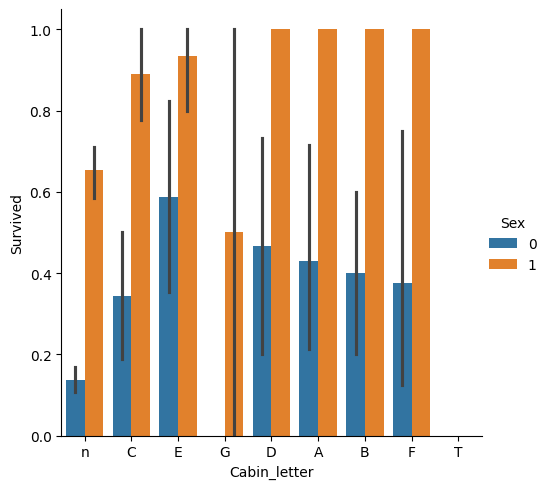

In [79]:
sns.catplot(data=combine, x='Cabin_letter', y='Survived', hue='Sex', kind='bar')

In [80]:
combine = combine.drop(['PassengerId', 'Name', 'Cabin','Ticket'],axis=1)

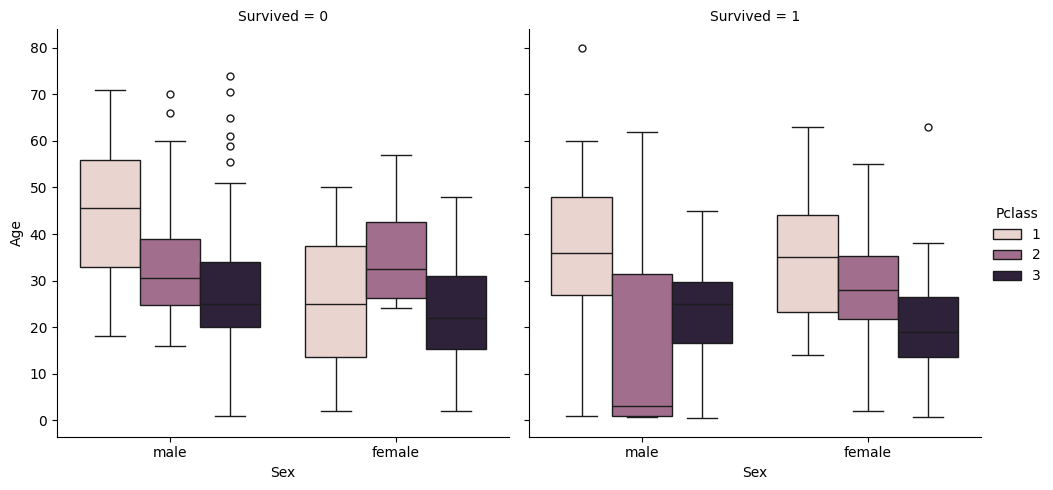

In [81]:
sns.catplot(data=train, x='Sex', y='Age', col='Survived', hue='Pclass', kind='box')

In [82]:
combine['Age'] = combine['Age'].astype(int)
combine['Pclass'] = combine['Pclass'].astype(int)

In [83]:
combine['Age/Pclass'] = combine['Age'] / combine['Pclass']

In [84]:
combine.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_letter,Age/Pclass
0,0.0,3,0,22,1,0,7.2500,S,Mr,n,7.333333
1,1.0,1,1,38,1,0,71.2833,C,Mrs,C,38.000000
2,1.0,3,1,26,0,0,7.9250,S,Miss,n,8.666667
3,1.0,1,1,35,1,0,53.1000,S,Mrs,C,35.000000
4,0.0,3,0,35,0,0,8.0500,S,Mr,n,11.666667


In [85]:
combine['Family_size'] = combine.SibSp + combine.Parch + 1


In [86]:
combine['Family_size'].value_counts()

Family_size
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64

In [87]:
combine['Is_Alone'] = 0
combine.loc[combine['Family_size']==1, 'Is_Alone'] = 1
combine = combine.drop(['SibSp', 'Parch', 'Family_size'],axis=1)

##### 6. Modeling.
* 6.1 Encoding categorical values.
* 6.2 Scaling numerical values.
* 6.3 Applying ML models with evaluation (score, f1, precision, recall).
    * Logistic Regression.
    * SVC Support Vector Machines.
    * Linear SVC.
    * SGD - Stochastic Gradient Decent.
    * K- Nearest Neigbours.
    * GNB - Gaussian Naive Base.
    * Perceptron.
    * DTC - Decision Tree CLassifier.
    * RF - Random Forest (ensable method).
    * Catboost.
    * Adaboost.
* 6.4 Compering all models & chosing the best performing one.
* 6.5 One more look at features, engineered features, Ticket, trying new features and reload models.
* 6.6 Creating a pipeline with selected models, applying PCA, Select-K features, hyperparameter tuning and cross validation.

##### 6.1 Encoding categorical values.

In [89]:
combine = pd.get_dummies(combine, columns=['Title'], dtype=int)
combine = pd.get_dummies(combine, columns=['Embarked'], prefix='Em', dtype=int)
combine = pd.get_dummies(combine, columns=['Cabin_letter'],prefix='Cl',dtype=int)

In [90]:
combine.head()

,Survived,Pclass,Sex,Age,Fare,Age/Pclass,Is_Alone,Title_Dr,Title_Master,Title_Miss,...,Em_S,Cl_A,Cl_B,Cl_C,Cl_D,Cl_E,Cl_F,Cl_G,Cl_T,Cl_n
0,0.0,3,0,22,7.2500,7.333333,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,1,1,38,71.2833,38.000000,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,3,1,26,7.9250,8.666667,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1.0,1,1,35,53.1000,35.000000,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0.0,3,0,35,8.0500,11.666667,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


##### 6.2 Scaling numerical values.

In [91]:
from sklearn.preprocessing import MinMaxScaler

In [92]:
scaler = MinMaxScaler()

In [97]:
features_selected = combine[['Age', 'Fare','Age/Pclass']]

In [98]:
combine[['Age', 'Fare', 'Age/Pclass']] = scaler.fit_transform(features_selected)

In [100]:
combine.head()

,Survived,Pclass,Sex,Age,Fare,Age/Pclass,Is_Alone,Title_Dr,Title_Master,Title_Miss,...,Em_S,Cl_A,Cl_B,Cl_C,Cl_D,Cl_E,Cl_F,Cl_G,Cl_T,Cl_n
0,0.0,3,0,0.2750,0.014151,0.091667,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,1,1,0.4750,0.139136,0.475000,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,3,1,0.3250,0.015469,0.108333,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1.0,1,1,0.4375,0.103644,0.437500,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0.0,3,0,0.4375,0.015713,0.145833,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [102]:
train = combine[:len(train)]
test = combine[len(train):]

In [103]:
train.shape

(891, 26)

In [105]:
test.shape

(418, 26)

In [109]:
features = train.drop('Survived', axis=1)
labels = train['Survived']
s_test = test

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

##### 6.3 Applying ML models with evaluation (score, f1, precision, recall).

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
PERF_FORMAT_STRING =" \tAccuracy: {:>0.{round}f}\tF1_score: {:>0.{round}f}\tPrecision: {:>0.{round}f}\tRecall: {:>0.{round}f} "

In [122]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_acc = lr_clf.score(X_train, y_train)
lr_f1_score = f1_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
print(PERF_FORMAT_STRING.format(lr_acc, lr_f1_score, lr_precision, lr_recall, round = 4))


 	Accuracy: 0.8379	F1_score: 0.7727	Precision: 0.7798	Recall: 0.7658 


In [125]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
svc_pred = svc_clf.predict(X_test)
svc_acc = svc_clf.score(X_train, y_train)
svc_f1_score = f1_score(y_test, svc_pred)
svc_precision = precision_score(y_test, svc_pred)
svc_recall = recall_score(y_test, svc_pred)
print(PERF_FORMAT_STRING.format(svc_acc, svc_f1_score, svc_precision, svc_recall, round = 4))

 	Accuracy: 0.8411	F1_score: 0.7449	Precision: 0.8588	Recall: 0.6577 


In [132]:
from sklearn.svm import LinearSVC
lsvc_clf = LinearSVC()
lsvc_clf.fit(X_train, y_train)
lsvc_pred = lsvc_clf.predict(X_test)
lsvc_acc = lsvc_clf.score(X_train, y_train)
lsvc_f1_score = f1_score(y_test, lsvc_pred)
lsvc_precision = precision_score(y_test, lsvc_pred)
lsvc_recall =recall_score(y_test, lsvc_pred)
print(PERF_FORMAT_STRING.format(lsvc_acc, lsvc_f1_score, lsvc_precision, lsvc_recall, round = 4))

 	Accuracy: 0.8283	F1_score: 0.7727	Precision: 0.7798	Recall: 0.7658 


In [134]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_pred = lsvc_clf.predict(X_test)
sgd_acc = lsvc_clf.score(X_train, y_train)
sgd_f1_score = f1_score(y_test, sgd_pred)
sgd_precision = precision_score(y_test, sgd_pred)
sgd_recall =recall_score(y_test, sgd_pred)
print(PERF_FORMAT_STRING.format(sgd_acc, sgd_f1_score, sgd_precision, sgd_recall, round = 4))

 	Accuracy: 0.8283	F1_score: 0.7727	Precision: 0.7798	Recall: 0.7658 


In [141]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
knn_acc = knn_clf.score(X_train, y_train)
knn_f1_score = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall =recall_score(y_test, knn_pred)
print(PERF_FORMAT_STRING.format(knn_acc, knn_f1_score, knn_precision, knn_recall, round = 4))

 	Accuracy: 0.8636	F1_score: 0.7220	Precision: 0.7872	Recall: 0.6667 


In [144]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_pred = gnb_clf.predict(X_test)
gnb_acc = gnb_clf.score(X_train, y_train)
gnb_f1_score = f1_score(y_test, gnb_pred)
gnb_precision = precision_score(y_test, gnb_pred)
gnb_recall = recall_score(y_test, gnb_pred)
print(PERF_FORMAT_STRING.format(gnb_acc, gnb_f1_score, gnb_precision, gnb_recall, round = 4))

 	Accuracy: 0.3820	F1_score: 0.5829	Precision: 0.4144	Recall: 0.9820 


In [146]:
from sklearn.linear_model import Perceptron

p_clf = Perceptron()
p_clf.fit(X_train, y_train)
p_pred = p_clf.predict(X_test)
p_acc = gnb_clf.score(X_train, y_train)
p_f1_score = f1_score(y_test, p_pred)
p_precision = precision_score(y_test, p_pred)
p_recall = recall_score(y_test, p_pred)
print(PERF_FORMAT_STRING.format(p_acc, p_f1_score, p_precision, p_recall, round = 4))

 	Accuracy: 0.3820	F1_score: 0.6845	Precision: 0.8421	Recall: 0.5766 


In [148]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
dt_acc = gnb_clf.score(X_train, y_train)
dt_f1_score = f1_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
print(PERF_FORMAT_STRING.format(dt_acc, dt_f1_score, dt_precision, dt_recall, round = 4))

 	Accuracy: 0.3820	F1_score: 0.7130	Precision: 0.7333	Recall: 0.6937 


In [155]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = dt_clf.predict(X_test)
rf_acc = gnb_clf.score(X_train, y_train)
rf_f1_score = f1_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
print(PERF_FORMAT_STRING.format(rf_acc, rf_f1_score, rf_precision, rf_recall, round = 4))

 	Accuracy: 0.3820	F1_score: 0.7130	Precision: 0.7333	Recall: 0.6937 


In [156]:
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier()
cb_clf.fit(X_train, y_train)
cb_pred = dt_clf.predict(X_test)
cb_acc = gnb_clf.score(X_train, y_train)
cb_f1_score = f1_score(y_test, cb_pred)
cb_precision = precision_score(y_test, cb_pred)
cb_recall = recall_score(y_test, cb_pred)
print(PERF_FORMAT_STRING.format(cb_acc, cb_f1_score, cb_precision, cb_recall, round = 4))

Learning rate set to 0.008417
0:	learn: 0.6881197	total: 162ms	remaining: 2m 41s
1:	learn: 0.6826920	total: 164ms	remaining: 1m 21s
2:	learn: 0.6779672	total: 166ms	remaining: 55.3s
3:	learn: 0.6734862	total: 168ms	remaining: 41.9s
4:	learn: 0.6685502	total: 170ms	remaining: 33.9s
5:	learn: 0.6629902	total: 173ms	remaining: 28.6s
6:	learn: 0.6577373	total: 175ms	remaining: 24.8s
7:	learn: 0.6526453	total: 177ms	remaining: 22s
8:	learn: 0.6475056	total: 180ms	remaining: 19.8s
9:	learn: 0.6429229	total: 182ms	remaining: 18s
10:	learn: 0.6388952	total: 184ms	remaining: 16.6s
11:	learn: 0.6344190	total: 187ms	remaining: 15.4s
12:	learn: 0.6295986	total: 189ms	remaining: 14.4s
13:	learn: 0.6257937	total: 191ms	remaining: 13.4s
14:	learn: 0.6216119	total: 193ms	remaining: 12.7s
15:	learn: 0.6169757	total: 195ms	remaining: 12s
16:	learn: 0.6137248	total: 197ms	remaining: 11.4s
17:	learn: 0.6097161	total: 199ms	remaining: 10.9s
18:	learn: 0.6075048	total: 202ms	remaining: 10.4s
19:	learn: 0.60

In [158]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
ab_pred = dt_clf.predict(X_test)
ab_acc = gnb_clf.score(X_train, y_train)
ab_f1_score = f1_score(y_test, ab_pred)
ab_precision = precision_score(y_test, ab_pred)
ab_recall = recall_score(y_test, ab_pred)
print(PERF_FORMAT_STRING.format(ab_acc, ab_f1_score, ab_precision, ab_recall, round = 4))

 	Accuracy: 0.3820	F1_score: 0.7130	Precision: 0.7333	Recall: 0.6937 
